We are trying to solve the problem of finding displacements in a 2D bar using Physics-Informed Neural Network. We will use different body forces and see how the displacement is affected in the x and y directions. 

We solve the PINN by the partial differantial equations given below. We will use different values of body forces 'f1' and 'f2' and compare the resulting heatmaps.



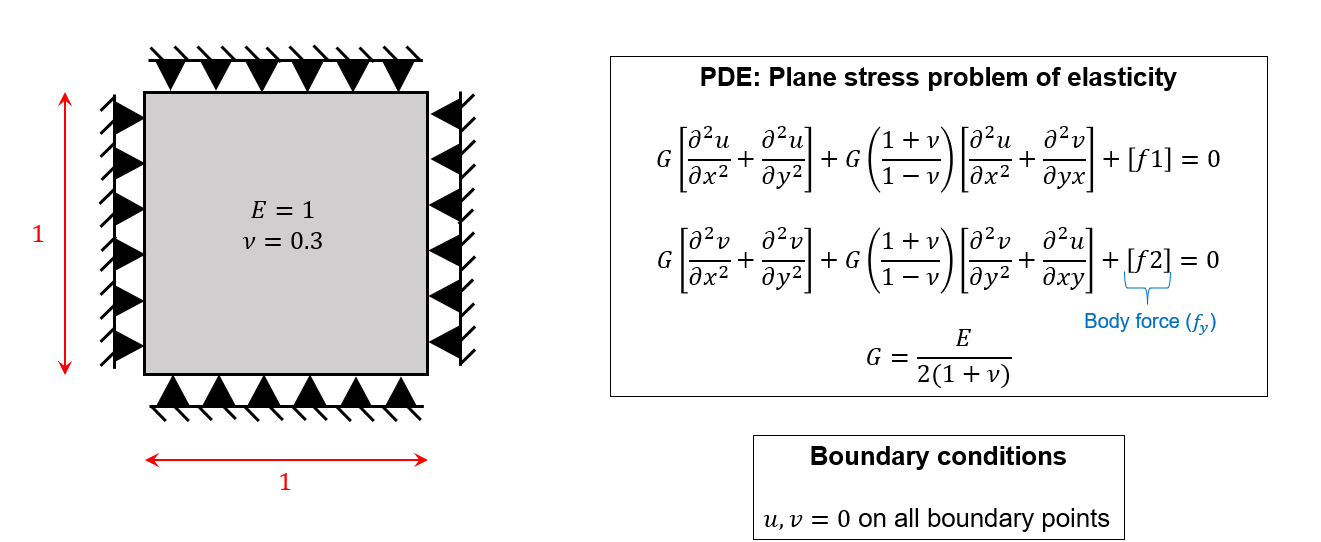

Case 1: \
$ f1  = sin(2*πx)sin(2*πy) $ \
$ f2  = sin(2*πx) + sin(2*πy) $


In [3]:
"""
Solution of 2D Forward Problem of Linear Elasticity
   for Plane Stress Boundary Value Problem using
      Physics-Informed Neural Networks (PINN)
"""
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import math

torch.manual_seed(123456)
np.random.seed(123456)

E = 1                                       # Young's Modulus
nu = 0.3                                    # Poisson Ratio
G = 0.5*E/(1+nu)                                          # Shear modulus

""" The function run is the main fucntion what contains all the code written as per the template. This function just takes two 
arguments: f1 and f2, the two body forces:"""

device = ("cuda" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Nnet = nn.Sequential()
        self.Nnet.add_module('Linear_layer_1', nn.Linear(2,30))    # First linear layer
        self.Nnet.add_module('Tanh_layer_1', nn.Tanh())
        self.Nnet.add_module('Linear_layer_2', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_2', nn.Tanh())
        self.Nnet.add_module('Linear_layer_3', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_3', nn.Tanh())
        self.Nnet.add_module('Linear_layer_4', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_4', nn.Tanh())
        self.Nnet.add_module('Linear_layer_5', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_5', nn.Tanh())
        self.Nnet.add_module('Output Layer', nn.Linear(30,2))       
        self.Nnet.to(device) 
        
        print(self.Nnet)                                        # Print model summary

    # Forward Feed
    def forward(self, x):
        y = self.Nnet(x)
        return y

    # PDE and BCs loss
    def loss(self, xy, xyb, u_b_train,v_b_train):
        y = self.forward(xy)                              # Interior Solution (output from from defined NN model)
        y_b = self.forward(xyb)                               # Boundary Solution (output from from defined NN model)
        u_b, v_b = y_b[:,0], y_b[:,1]                        # u and v boundary
        u,v = y[:,0], y[:,1]                              # u and v interior

        # Calculate Gradients
        # Gradients of deformation in x-direction (first and second derivatives)
        u_g = gradients(u, xy)[0]                              # Gradient of u, Du = [u_x, u_y]
        u_x, u_y = u_g[:,0], u_g[:,1]                        # [u_x, u_y]
        u_xx = gradients(u_x, xy)[0][:,0]                             # Second derivative, u_xx
        u_xy = gradients(u_x, xy)[0][:,1]                             # Mixed partial derivative, u_xy
        u_yy = gradients(u_y, xy)[0][:,1]                             # Second derivative, u_yy

        # Gradients of deformation in y-direction (first and second derivatives)
        v_g = gradients(v, xy)[0]                              # Gradient of v, Dv = [v_x, v_y]
        v_x, v_y = v_g[:,0], v_g[:,1]                          # [v_x, v_y]
        v_xx = gradients(v_x, xy)[0][:,0]                             # Second derivative, v_xx
        v_xy = gradients(v_x, xy)[0][:,1]                            # Mixed partial derivative, v_xy
        v_yy = gradients(v_y, xy)[0][:,1]                             # Second derivative, v_yy

        f_1 = torch.sin(2*math.pi*xy[:,0])*torch.sin(2*math.pi*xy[:,1])                               # Define body force for PDE-1
        f_2 = torch.sin(math.pi*xy[:,0])+torch.sin(2*math.pi*xy[:,1])                               # Define body force for PDE-2
        
        loss_1 = G*(u_xx + u_yy) + G*((1+nu)/(1-nu))*(u_xx + v_xy) + f_1                           # Define loss for PDE-1
        loss_2 = G*(v_xx + v_yy) + G*((1 + nu) / (1 - nu))*(u_xy + v_yy) + f_2                           # Define loss for PDE-2

        loss_fn = nn.MSELoss()
        loss_PDE = torch.mean((loss_1 - torch.zeros_like(loss_1))**2) + torch.mean((loss_2 - torch.zeros_like(loss_2))**2)                         # MSE PDE loss
        loss_bc = torch.mean((u_b - u_b_train)**2) + torch.mean((v_b - v_b_train)**2)        #check                 # MSE BCs loss

        TotalLoss = loss_PDE + 1e4*loss_bc
        if epoch %50 ==0:
            print(f'epoch {epoch}: loss_pde {loss_PDE:.8f}, loss_bc {loss_bc:.8f}')
        return TotalLoss

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, create_graph=True)

# Define model parameters here




# Load the collocation point data
data = scipy.io.loadmat("interior_points.mat")
x = data['x']
y = data['y']
xy = np.concatenate((x, y), axis=1)


data1 = scipy.io.loadmat("boundary_points.mat")

xb = data1['x_bdry']
yb = data1['y_bdry']
xyb = np.concatenate((xb,yb), axis=1)



## Define data as PyTorch Tensor and send to device
xy_f_train = torch.tensor(xy, requires_grad=True, dtype=torch.float32).to(device)
xy_b_train = torch.tensor(xyb, requires_grad=True, dtype=torch.float32).to(device)

# Define the boundary condition values
u_b_train = torch.zeros_like(xy_b_train[:,0])
v_b_train = torch.zeros_like(xy_b_train[:,1])

# Initialize model
model = Model().to(device)

# Loss and Optimizer
optimizer = torch.optim.Adam(params = model.parameters())

# Training
def train(epoch):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss = model.loss(xy_f_train, xy_b_train, u_b_train,v_b_train)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    if epoch%50==0:
        print(f'epoch {epoch}: loss {loss:.8f} ')
    return loss

for epoch in range(10000):
    train(epoch)

# %%
''' Testing PINN '''
# Generate collocation points and use trained model for testing
def sample_bound(num = 100):
    x1 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    x1 = torch.cat((x1, torch.zeros_like(x1)), dim = 1)
    x2 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)
    x2 = torch.cat((x2, torch.ones_like(x2)), dim = 1)

    s1 = torch.cat((x1,x2), dim=0)

    y1 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    y1 = torch.cat((torch.zeros_like(y1),y1), dim = 1)
    y2 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    y2 = torch.cat((torch.ones_like(y2),y2), dim = 1)

    s2 = torch.cat((y1,y2), dim=0)

    return torch.cat((s1,s2), dim=0)
test_samples_b = sample_bound(100)

num_samples = 2000
test_samples = torch.rand(num_samples,2, requires_grad = True)

u_b_test = torch.zeros_like(test_samples_b)[:,0]
v_b_test = torch.zeros_like(test_samples_b)[:,1]
model.loss(test_samples, test_samples_b, u_b_test,v_b_test)
    
# %%
''' Plotting '''
def plot_grid(test_samples, test_samples_b):
    test_pred = model.forward(test_samples)
    test_pred_b = model.forward(test_samples_b)
    pred_test_cat = torch.cat((test_pred, test_pred_b), dim = 0).detach().numpy()
    xy_cat = torch.cat((test_samples, test_samples_b), dim=0).detach().numpy()
    u = pred_test_cat[:,0]
    v = pred_test_cat[:,1]
    x = xy_cat[:,0]
    y = xy_cat[:,1]    
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    # Interpolate the data onto the grid
    U = griddata((x, y), u, (X, Y), method='linear')
    V = griddata((x, y), v, (X, Y), method='linear')

    # Plot the results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    im1 = ax1.imshow(U, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    im2 = ax2.imshow(V, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

    ax1.set_title('Displacement in x direction')
    ax2.set_title('Displacement in y direction')
    plt.show()


Sequential(
  (Linear_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_1): Tanh()
  (Linear_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_2): Tanh()
  (Linear_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_3): Tanh()
  (Linear_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_4): Tanh()
  (Linear_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_5): Tanh()
  (Output Layer): Linear(in_features=30, out_features=2, bias=True)
)
epoch 0: loss_pde 1.26040471, loss_bc 0.05886918
epoch 0: loss 589.95214844 
epoch 50: loss_pde 1.22173893, loss_bc 0.00001238
epoch 50: loss 1.34552908 
epoch 100: loss_pde 1.22146499, loss_bc 0.00000232
epoch 100: loss 1.24464059 
epoch 150: loss_pde 1.22102392, loss_bc 0.00000214
epoch 150: loss 1.24243832 
epoch 200: loss_pde 1.22051144, loss_bc 0.00000199
epoch 200: loss 1.24038970 
epoch 250: loss_pde 1.21991909, loss_bc 0.000001

epoch 4750: loss_pde 0.41878089, loss_bc 0.00000610
epoch 4750: loss 0.47974211 
epoch 4800: loss_pde 0.40063182, loss_bc 0.00000665
epoch 4800: loss 0.46712744 
epoch 4850: loss_pde 0.38197815, loss_bc 0.00000753
epoch 4850: loss 0.45726794 
epoch 4900: loss_pde 0.41255224, loss_bc 0.00000724
epoch 4900: loss 0.48497158 
epoch 4950: loss_pde 0.39462596, loss_bc 0.00000639
epoch 4950: loss 0.45853764 
epoch 5000: loss_pde 0.37730950, loss_bc 0.00000689
epoch 5000: loss 0.44617364 
epoch 5050: loss_pde 0.36025125, loss_bc 0.00000743
epoch 5050: loss 0.43456805 
epoch 5100: loss_pde 0.34396982, loss_bc 0.00000797
epoch 5100: loss 0.42364979 
epoch 5150: loss_pde 0.32897469, loss_bc 0.00000841
epoch 5150: loss 0.41308674 
epoch 5200: loss_pde 0.36129546, loss_bc 0.00000969
epoch 5200: loss 0.45818850 
epoch 5250: loss_pde 0.34936348, loss_bc 0.00000680
epoch 5250: loss 0.41737264 
epoch 5300: loss_pde 0.33095247, loss_bc 0.00000725
epoch 5300: loss 0.40344420 
epoch 5350: loss_pde 0.31436

epoch 9850: loss_pde 0.13057451, loss_bc 0.00000495
epoch 9850: loss 0.18012305 
epoch 9900: loss_pde 0.12835005, loss_bc 0.00000502
epoch 9900: loss 0.17850956 
epoch 9950: loss_pde 0.13101232, loss_bc 0.00000504
epoch 9950: loss 0.18139625 


Train Samples: 


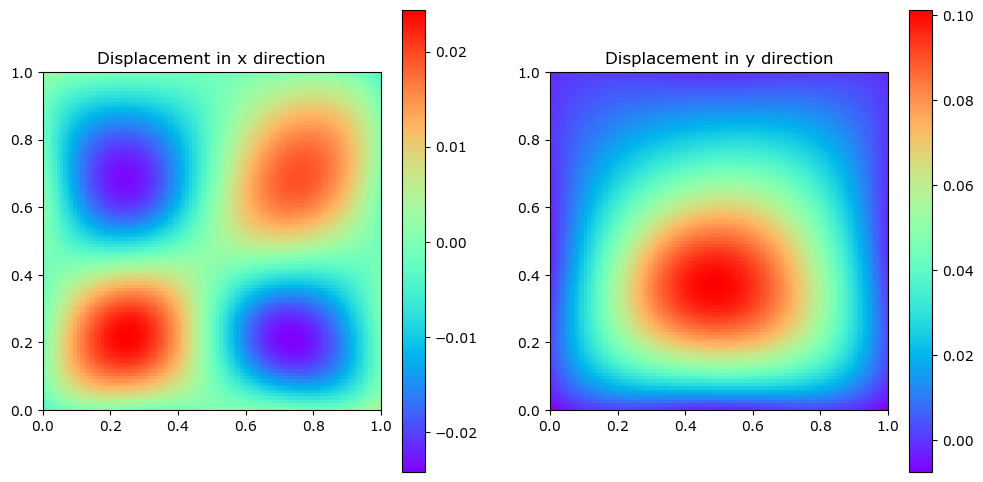

Test Samples: 


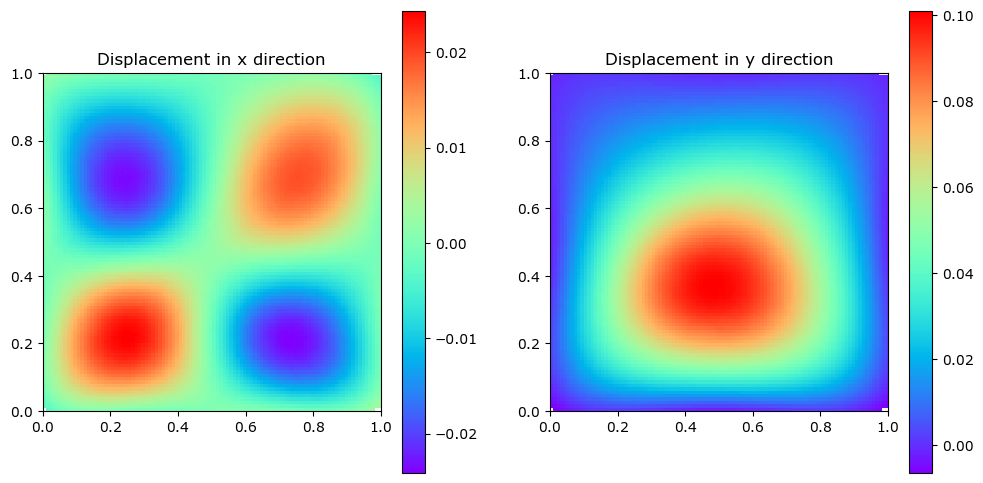

In [4]:
print("Train Samples: ")    
plot_grid(xy_f_train, xy_b_train)
print("Test Samples: ")
plot_grid(test_samples, test_samples_b)

Case 1: \
$ f1  = sin(2*πx) + sin(2*πy) $ \
$ f2  = sin(2*πx)  $


In [5]:



class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Nnet = nn.Sequential()
        self.Nnet.add_module('Linear_layer_1', nn.Linear(2,30))    # First linear layer
        self.Nnet.add_module('Tanh_layer_1', nn.Tanh())
        self.Nnet.add_module('Linear_layer_2', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_2', nn.Tanh())
        self.Nnet.add_module('Linear_layer_3', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_3', nn.Tanh())
        self.Nnet.add_module('Linear_layer_4', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_4', nn.Tanh())
        self.Nnet.add_module('Linear_layer_5', nn.Linear(30,30))
        self.Nnet.add_module('Tanh_layer_5', nn.Tanh())
        self.Nnet.add_module('Output Layer', nn.Linear(30,2))       
        
        
        print(self.Nnet)                                        # Print model summary

    # Forward Feed
    def forward(self, x):
        y = self.Nnet(x)
        return y

    # PDE and BCs loss
    def loss(self, xy, xyb, u_b_train,v_b_train):
        y = self.forward(xy)                              # Interior Solution (output from from defined NN model)
        y_b = self.forward(xyb)                               # Boundary Solution (output from from defined NN model)
        u_b, v_b = y_b[:,0], y_b[:,1]                        # u and v boundary
        u,v = y[:,0], y[:,1]                              # u and v interior

        # Calculate Gradients
        # Gradients of deformation in x-direction (first and second derivatives)
        u_g = gradients(u, xy)[0]                              # Gradient of u, Du = [u_x, u_y]
        u_x, u_y = u_g[:,0], u_g[:,1]                        # [u_x, u_y]
        u_xx = gradients(u_x, xy)[0][:,0]                             # Second derivative, u_xx
        u_xy = gradients(u_x, xy)[0][:,1]                             # Mixed partial derivative, u_xy
        u_yy = gradients(u_y, xy)[0][:,1]                             # Second derivative, u_yy

        # Gradients of deformation in y-direction (first and second derivatives)
        v_g = gradients(v, xy)[0]                              # Gradient of v, Dv = [v_x, v_y]
        v_x, v_y = v_g[:,0], v_g[:,1]                          # [v_x, v_y]
        v_xx = gradients(v_x, xy)[0][:,0]                             # Second derivative, v_xx
        v_xy = gradients(v_x, xy)[0][:,1]                            # Mixed partial derivative, v_xy
        v_yy = gradients(v_y, xy)[0][:,1]                             # Second derivative, v_yy

        f_1 = torch.sin(2*math.pi*xy[:,0]) + torch.sin(2*math.pi*xy[:,1])                              
        f_2 = torch.sin(math.pi*xy[:,0])
        
        loss_1 = G*(u_xx + u_yy) + G*((1+nu)/(1-nu))*(u_xx + v_xy) + f_1                           # Define loss for PDE-1
        loss_2 = G*(v_xx + v_yy) + G*((1 + nu) / (1 - nu))*(u_xy + v_yy) + f_2                           # Define loss for PDE-2

        loss_fn = nn.MSELoss()
        loss_PDE = torch.mean((loss_1 - torch.zeros_like(loss_1))**2) + torch.mean((loss_2 - torch.zeros_like(loss_2))**2)                         # MSE PDE loss
        loss_bc = torch.mean((u_b - u_b_train)**2) + torch.mean((v_b - v_b_train)**2)        #check                 # MSE BCs loss

        TotalLoss = loss_PDE + 1e4*loss_bc
        if epoch %50 ==0:
            print(f'epoch {epoch}: loss_pde {loss_PDE:.8f}, loss_bc {loss_bc:.8f}')
        return TotalLoss

def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, create_graph=True)

# Define model parameters here
device = ("cuda" if torch.cuda.is_available() else "cpu")



# Load the collocation point data
data = scipy.io.loadmat("interior_points.mat")
x = data['x']
y = data['y']
xy = np.concatenate((x, y), axis=1)


data1 = scipy.io.loadmat("boundary_points.mat")

xb = data1['x_bdry']
yb = data1['y_bdry']
xyb = np.concatenate((xb,yb), axis=1)



## Define data as PyTorch Tensor and send to device
xy_f_train = torch.tensor(xy, requires_grad=True, dtype=torch.float32).to(device)
xy_b_train = torch.tensor(xyb, requires_grad=True, dtype=torch.float32).to(device)

# Define the boundary condition values
u_b_train = torch.zeros_like(xy_b_train[:,0])
v_b_train = torch.zeros_like(xy_b_train[:,1])

# Initialize model
model = Model().to(device)

# Loss and Optimizer
optimizer = torch.optim.Adam(params = model.parameters())

# Training
def train(epoch):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss = model.loss(xy_f_train, xy_b_train, u_b_train,v_b_train)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    if epoch%50==0:
        print(f'epoch {epoch}: loss {loss:.8f} ')
    return loss

for epoch in range(10000):
    train(epoch)

# %%
''' Testing PINN '''
# Generate collocation points and use trained model for testing
def sample_bound(num = 100):
    x1 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    x1 = torch.cat((x1, torch.zeros_like(x1)), dim = 1)
    x2 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)
    x2 = torch.cat((x2, torch.ones_like(x2)), dim = 1)

    s1 = torch.cat((x1,x2), dim=0)

    y1 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    y1 = torch.cat((torch.zeros_like(y1),y1), dim = 1)
    y2 = torch.rand(100, requires_grad=True).unsqueeze(dim=1)

    y2 = torch.cat((torch.ones_like(y2),y2), dim = 1)

    s2 = torch.cat((y1,y2), dim=0)

    return torch.cat((s1,s2), dim=0)
test_samples_b = sample_bound(100)

num_samples = 2000
test_samples = torch.rand(num_samples,2, requires_grad = True)

u_b_test = torch.zeros_like(test_samples_b)[:,0]
v_b_test = torch.zeros_like(test_samples_b)[:,1]
model.loss(test_samples, test_samples_b, u_b_test,v_b_test)
    
# %%
''' Plotting '''
def plot_grid(test_samples, test_samples_b):
    test_pred = model.forward(test_samples)
    test_pred_b = model.forward(test_samples_b)
    pred_test_cat = torch.cat((test_pred, test_pred_b), dim = 0).detach().numpy()
    xy_cat = torch.cat((test_samples, test_samples_b), dim=0).detach().numpy()
    u = pred_test_cat[:,0]
    v = pred_test_cat[:,1]
    x = xy_cat[:,0]
    y = xy_cat[:,1]    
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    # Interpolate the data onto the grid
    U = griddata((x, y), u, (X, Y), method='linear')
    V = griddata((x, y), v, (X, Y), method='linear')

    # Plot the results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    im1 = ax1.imshow(U, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    im2 = ax2.imshow(V, cmap='rainbow', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

    ax1.set_title('Displacement in x direction')
    ax2.set_title('Displacement in y direction')
    plt.show()


Sequential(
  (Linear_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_1): Tanh()
  (Linear_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_2): Tanh()
  (Linear_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_3): Tanh()
  (Linear_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_4): Tanh()
  (Linear_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_5): Tanh()
  (Output Layer): Linear(in_features=30, out_features=2, bias=True)
)
epoch 0: loss_pde 1.47575235, loss_bc 0.00912336
epoch 0: loss 92.70935059 
epoch 50: loss_pde 1.46659374, loss_bc 0.00000813
epoch 50: loss 1.54791689 
epoch 100: loss_pde 1.46451974, loss_bc 0.00000074
epoch 100: loss 1.47196221 
epoch 150: loss_pde 1.46115065, loss_bc 0.00000053
epoch 150: loss 1.46644926 
epoch 200: loss_pde 1.45708251, loss_bc 0.00000049
epoch 200: loss 1.46203136 
epoch 250: loss_pde 1.45240986, loss_bc 0.0000005

epoch 4750: loss_pde 0.27287722, loss_bc 0.00001165
epoch 4750: loss 0.38935220 
epoch 4800: loss_pde 0.26957595, loss_bc 0.00000588
epoch 4800: loss 0.32840052 
epoch 4850: loss_pde 0.26450467, loss_bc 0.00000589
epoch 4850: loss 0.32337254 
epoch 4900: loss_pde 0.26038200, loss_bc 0.00000589
epoch 4900: loss 0.31928968 
epoch 4950: loss_pde 0.25862995, loss_bc 0.00001508
epoch 4950: loss 0.40946817 
epoch 5000: loss_pde 0.25699940, loss_bc 0.00000575
epoch 5000: loss 0.31447321 
epoch 5050: loss_pde 0.25284332, loss_bc 0.00000576
epoch 5050: loss 0.31042191 
epoch 5100: loss_pde 0.25403523, loss_bc 0.00000883
epoch 5100: loss 0.34237769 
epoch 5150: loss_pde 0.25144500, loss_bc 0.00000565
epoch 5150: loss 0.30797869 
epoch 5200: loss_pde 0.24707349, loss_bc 0.00000566
epoch 5200: loss 0.30370173 
epoch 5250: loss_pde 0.24917284, loss_bc 0.00001989
epoch 5250: loss 0.44806772 
epoch 5300: loss_pde 0.24569137, loss_bc 0.00000555
epoch 5300: loss 0.30114695 
epoch 5350: loss_pde 0.24089

epoch 9850: loss_pde 0.15531544, loss_bc 0.00000360
epoch 9850: loss 0.19129941 
epoch 9900: loss_pde 0.15353328, loss_bc 0.00000787
epoch 9900: loss 0.23218757 
epoch 9950: loss_pde 0.15894265, loss_bc 0.00000384
epoch 9950: loss 0.19730102 


Train Samples: 


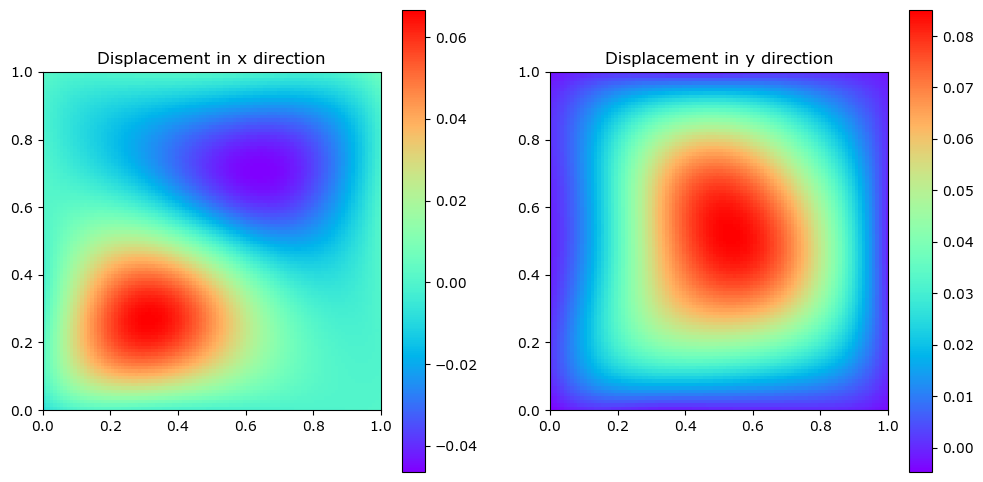

Test Samples: 


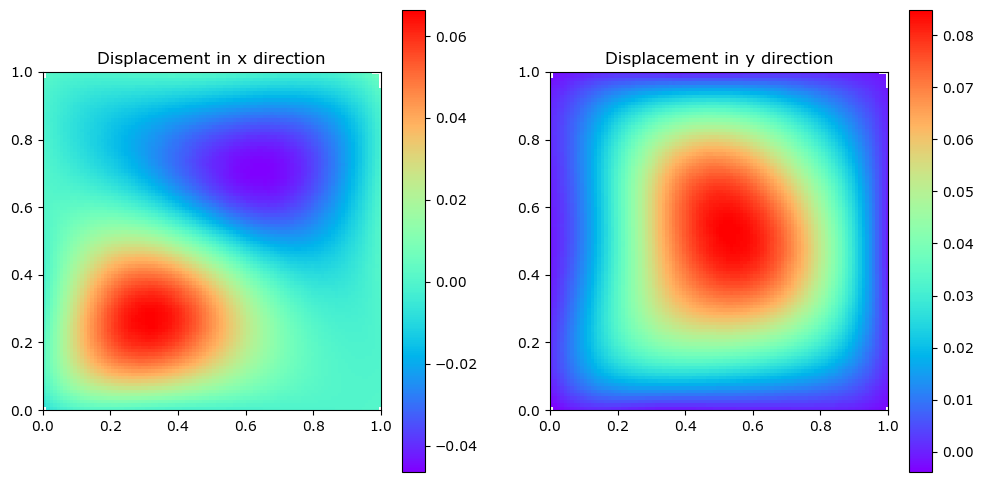

In [6]:
print("Train Samples: ")    
plot_grid(xy_f_train, xy_b_train)
print("Test Samples: ")
plot_grid(test_samples, test_samples_b)

Similarly, we can have different test cases where we have different types of body forces applied to objects and their displacement responses can be plotted very accurately